# HAM10000 Training with Distance Weight

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

# created library
import mydata
from mymodels import TransDataset, LoadDataset, VGG16Model, ResNet50Model, EfficientB7Model

In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない
from distancetraining import ModelTrainer

# Efficientnet

In [28]:
db = "HAM"
model_name = "efficientnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

In [29]:
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [30]:
ycol="labels"
batch_size = 8 # １インプットずつペナルティを付加するため

ld = LoadDataset(df_train, df_valid, df_test, ycol, batch_size)
train_loader, valid_loader, test_loader = ld.create_dataloaders()

H*W:  (450, 600)


Validation Accuracy: 0.5023 | Loss: 0.6219 | F1: 0.0092 | AUC: 0.8812
Validation Accuracy: 0.7604 | Loss: 0.4816 | F1: 0.7045 | AUC: 0.9000
Validation Accuracy: 0.7903 | Loss: 0.4183 | F1: 0.7479 | AUC: 0.9257
Validation Accuracy: 0.7281 | Loss: 0.4291 | F1: 0.6424 | AUC: 0.9274
Validation Accuracy: 0.7535 | Loss: 0.3971 | F1: 0.6899 | AUC: 0.9350
Validation Accuracy: 0.8018 | Loss: 0.3812 | F1: 0.7688 | AUC: 0.9375
Validation Accuracy: 0.7926 | Loss: 0.3760 | F1: 0.7514 | AUC: 0.9384
Validation Accuracy: 0.8295 | Loss: 0.3510 | F1: 0.8093 | AUC: 0.9413
Validation Accuracy: 0.8295 | Loss: 0.3412 | F1: 0.8042 | AUC: 0.9449
Validation Accuracy: 0.8502 | Loss: 0.3234 | F1: 0.8387 | AUC: 0.9434
Validation Accuracy: 0.8041 | Loss: 0.3477 | F1: 0.7658 | AUC: 0.9465
Validation Accuracy: 0.8502 | Loss: 0.3183 | F1: 0.8338 | AUC: 0.9482
Validation Accuracy: 0.8502 | Loss: 0.2975 | F1: 0.8338 | AUC: 0.9538
Validation Accuracy: 0.8525 | Loss: 0.2901 | F1: 0.8376 | AUC: 0.9516
Validation Accuracy:

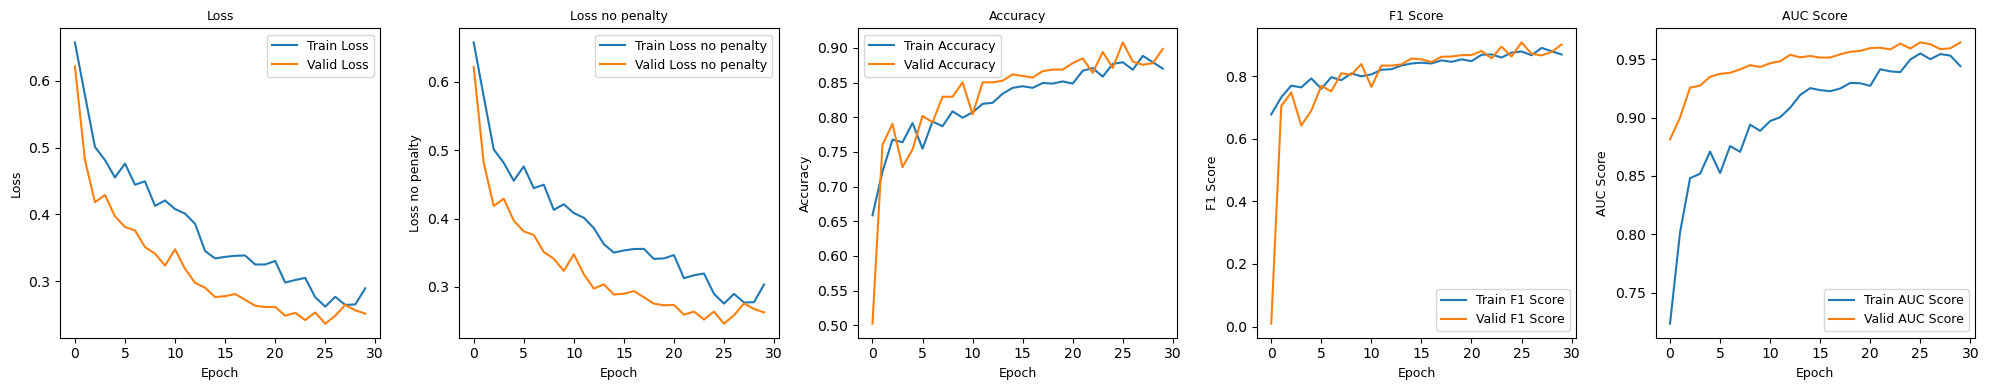

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientB7Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 30
lr = 1e-5
start = 12
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

In [32]:
def evaluations(trainer, model, valid_loader, df, df_filepath):
    test_predictions, test_outputs = trainer.evaluate(model, valid_loader)
    tmp = df.copy()
    tmp["predictions"] = test_predictions
    tmp["proba"] = test_outputs
    tmp.to_csv(df_filepath, index=False)
    trainer.report(tmp)

In [33]:
model = EfficientB7Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       217
           1       0.87      0.95      0.91       217

    accuracy                           0.90       434
   macro avg       0.90      0.90      0.90       434
weighted avg       0.90      0.90      0.90       434

Skin tone 1: Accuracy 0.9009216589861752


In [34]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       217
           1       0.90      0.89      0.90       217

    accuracy                           0.90       434
   macro avg       0.90      0.90      0.90       434
weighted avg       0.90      0.90      0.90       434

Skin tone 1: Accuracy 0.8963133640552995


# Resnet

In [10]:
model_name = "resnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered interna

Validation Accuracy: 0.5530 | Loss: 0.6093 | F1: 0.2302 | AUC: 0.8760
Validation Accuracy: 0.8272 | Loss: 0.4147 | F1: 0.8268 | AUC: 0.9119
Validation Accuracy: 0.7696 | Loss: 0.3907 | F1: 0.7354 | AUC: 0.9107
Validation Accuracy: 0.8249 | Loss: 0.3566 | F1: 0.8119 | AUC: 0.9229
Validation Accuracy: 0.8272 | Loss: 0.3471 | F1: 0.8062 | AUC: 0.9321
Validation Accuracy: 0.7719 | Loss: 0.3737 | F1: 0.7163 | AUC: 0.9332
Validation Accuracy: 0.7926 | Loss: 0.3505 | F1: 0.7568 | AUC: 0.9342
Validation Accuracy: 0.8456 | Loss: 0.3301 | F1: 0.8386 | AUC: 0.9358
Validation Accuracy: 0.7627 | Loss: 0.3817 | F1: 0.6997 | AUC: 0.9321
Validation Accuracy: 0.7788 | Loss: 0.3615 | F1: 0.7241 | AUC: 0.9404
Validation Accuracy: 0.8134 | Loss: 0.3311 | F1: 0.7769 | AUC: 0.9422
Validation Accuracy: 0.8479 | Loss: 0.3078 | F1: 0.8342 | AUC: 0.9446
Validation Accuracy: 0.8410 | Loss: 0.3216 | F1: 0.8253 | AUC: 0.9412
Validation Accuracy: 0.8272 | Loss: 0.3099 | F1: 0.8062 | AUC: 0.9432
Validation Accuracy:

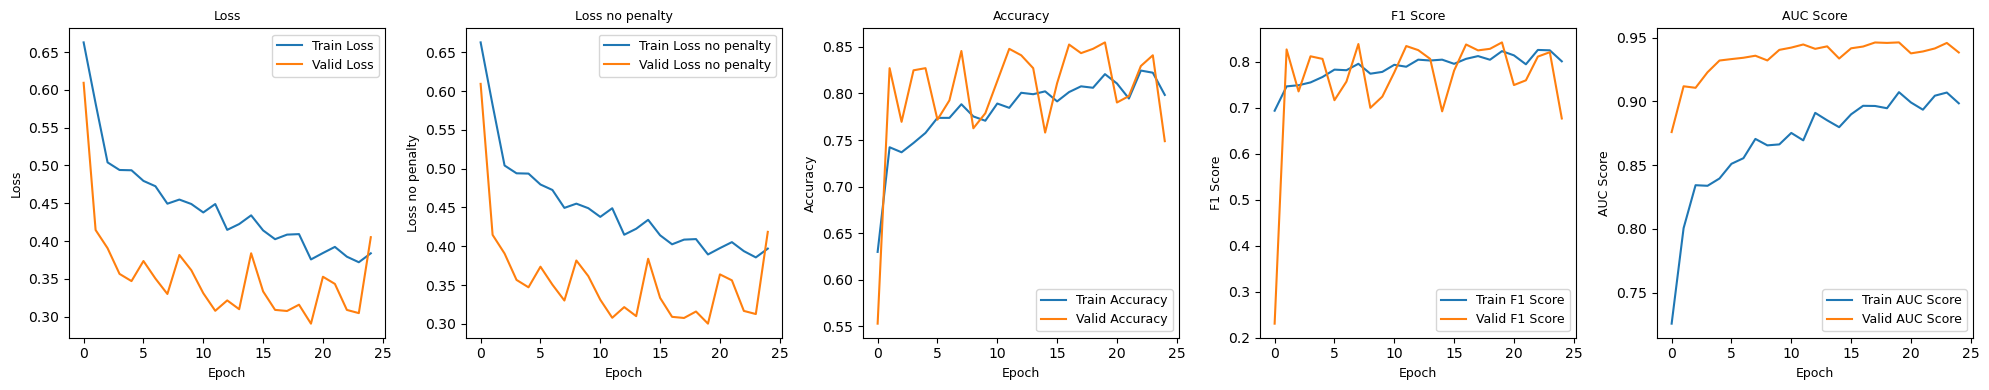

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 25
lr = 1e-5
start = 18
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

In [12]:
model = ResNet50Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       217
           1       0.89      0.85      0.87       217

    accuracy                           0.87       434
   macro avg       0.87      0.87      0.87       434
weighted avg       0.87      0.87      0.87       434

Skin tone 1: Accuracy 0.8709677419354839


In [13]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       217
           1       0.89      0.82      0.85       217

    accuracy                           0.85       434
   macro avg       0.86      0.85      0.85       434
weighted avg       0.86      0.85      0.85       434

Skin tone 1: Accuracy 0.8548387096774194


# VGG

In [51]:
model_name = "vgg"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 25
lr = 1e-6
start = 15
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

Validation Accuracy: 0.5046 | Loss: 0.6627 | F1: 0.0183 | AUC: 0.8371
Validation Accuracy: 0.7627 | Loss: 0.6217 | F1: 0.7115 | AUC: 0.8823
Validation Accuracy: 0.7857 | Loss: 0.5979 | F1: 0.8129 | AUC: 0.8887
Validation Accuracy: 0.7765 | Loss: 0.5565 | F1: 0.8064 | AUC: 0.8946
Validation Accuracy: 0.8018 | Loss: 0.5046 | F1: 0.8216 | AUC: 0.8967
Validation Accuracy: 0.8065 | Loss: 0.4899 | F1: 0.8257 | AUC: 0.8989
Validation Accuracy: 0.8018 | Loss: 0.4726 | F1: 0.8186 | AUC: 0.8993
Validation Accuracy: 0.8134 | Loss: 0.4564 | F1: 0.8243 | AUC: 0.8980
Validation Accuracy: 0.8134 | Loss: 0.4751 | F1: 0.8337 | AUC: 0.9064
Validation Accuracy: 0.8157 | Loss: 0.4564 | F1: 0.8333 | AUC: 0.9071
Validation Accuracy: 0.8180 | Loss: 0.4444 | F1: 0.8337 | AUC: 0.9104
Validation Accuracy: 0.8157 | Loss: 0.4381 | F1: 0.8305 | AUC: 0.9087
Validation Accuracy: 0.8157 | Loss: 0.4359 | F1: 0.8305 | AUC: 0.9099


In [ ]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

In [ ]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)